In [1]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


### 1. Получаем векторные представления новостей

In [4]:
# %pip install gensim

In [5]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [6]:
# %pip install razdel
# %pip install pymorphy2
# %pip install --upgrade nltk
# import nltk
# nltk.download('stopwords')

In [7]:
#предобработка текстов
import re
import numpy as np

from nltk.corpus import stopwords

#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel

import pymorphy2  

In [8]:
stopword_ru = stopwords.words('russian')

len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [9]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

777

In [10]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [11]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

CPU times: user 29.7 s, sys: 453 ms, total: 30.1 s
Wall time: 30.7 s


In [12]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 4min, sys: 3.24 s, total: 4min 3s
Wall time: 4min 24s


А теперь в 3 строчки обучим нашу модель

In [13]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, тропический, углеродный, цикл, чув...
26999    [жить, примерно, тыс, назад, территория, совре...
Name: title, Length: 27000, dtype: object

In [14]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [15]:
common_dictionary[10]

'взаимодействие'

In [16]:
common_corpus

[[(0, 2),
  (1, 1),
  (2, 2),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 4),
  (16, 1),
  (17, 1),
  (18, 4),
  (19, 1),
  (20, 1),
  (21, 3),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 2),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 2),
  (45, 1),
  (46, 2),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 3),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 3),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 3),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 3),
  (89, 2),
  (90, 1)],
 [(91, 2

Все просто - это словарь наших слов

Запускаем обучение

In [17]:
from gensim.models import LdaModel

In [18]:
# LdaModel?

In [19]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 53.5 s, sys: 1.09 s, total: 54.6 s
Wall time: 35.4 s


In [20]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [21]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(10, 0.036697574), (23, 0.9389777)]

In [22]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: рейс граница следствие выяснить завод сенатор перевод
topic_1: вуз флот экипаж вероятно кость альянс калифорния
topic_2: очень всё снижение уровень научный земля большой
topic_3: эксперимент остров строительство область тыс площадь ремонт
topic_4: писать товар место университет журнал британский рейтинг
topic_5: рынок новый век поверхность первый школа доллар
topic_6: тело штат экипаж жертва местный белоруссия произойти
topic_7: россия день операция всё газета министерство наука
topic_8: женщина лечение врач мужчина офицер полоса умереть
topic_9: смерть инвестиция фотография болезнь сократиться ск бомба
topic_10: ракета гражданин народный фронт артист курение зампред
topic_11: рубль квартира цена спрос реформа египет фонд
topic_12: пострадать миссия район страдать авария турция граница
topic_13: млн тыс млрд составить автор рост первый
topic_14: военный армия погибнуть взрыв станция боевой катастрофа
topic_15: земля дыра ступень отряд законодательство учреждение киев
topic_16:

In [23]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [24]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.896778,0.0,0.01091,0.031849,0.0
1,4896,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.05081,0.0,0.0,0.0,0.000000,0.0,0.00000,0.325063,0.0
2,4897,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.938970,0.0
3,4898,0.0,0.0,0.438224,0.000000,0.000000,0.145507,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.161703,0.0
4,4899,0.0,0.0,0.000000,0.086217,0.319459,0.000000,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.487689,0.0,0.00000,0.081806,0.0


### Следующий шаг - векторные представления пользователей

In [25]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [26]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [27]:
doc_dict[293622]

array([0.05952308, 0.        , 0.0362432 , 0.026839  , 0.14409079,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01875457, 0.        , 0.        , 0.28162077, 0.        ,
       0.        , 0.0916628 , 0.        , 0.26554474, 0.        ,
       0.0646624 , 0.        , 0.        , 0.        , 0.        ])

In [28]:
user_articles_list = users['articles'].iloc[33]

# def get_user_embedding(user_articles_list):
#     user_articles_list = eval(user_articles_list)
#     user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
#     user_vector = np.mean(user_vector, 0)
#     return user_vector

# roc_auc (mean) = 0.9424199081341939
# Best Threshold=0.223766, F-Score=0.653, Precision=0.552, Recall=0.800


In [45]:
# РЕШЕНИЕ

# def get_user_embedding(user_articles_list):
#     user_articles_list = eval(user_articles_list)
#     user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
#     user_vector = np.median(user_vector, 0)
#     return user_vector

# # roc_auc (median) = 0.9643304843304844
# Best Threshold=0.260958, F-Score=0.730, Precision=0.671, Recall=0.800

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

# roc_auc (max) = 0.972607709750567
# Best Threshold=0.349944, F-Score=0.779, Precision=0.767, Recall=0.792


<table>
    <tr>
        <th></th>
        <th>roc_auc</th>
        <th>Precision</th>
        <th>Recall</th>
        <th>F-Score</th>
    </tr>
    <tr>
        <td><b>mean</b></td>
        <td>0.9424199081341939</td>
        <td>0.552</td>
        <td>0.800</td>
        <td>0.653</td>
    </tr>
    <tr>
        <td><b>median</b></td>
        <td>0.9643304843304844</td>
        <td>0.671</td>
        <td>0.800</td>
        <td>0.730</td>
    </tr>
    <tr>
        <td><b>max</b></td>
        <td>0.972607709750567</td>
        <td>0.767</td>
        <td>0.792</td>
        <td>0.779</td>
    </tr>
</table>

In [30]:
# ВЫВОД

# Так как в матрице topic_matrix используются значения вероятностей, то логичнее предположить,
# что использование метода max приведет к лучшим показателям.

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [46]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [32]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [33]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.059523,0.042911,0.036243,0.221877,0.144091,0.627392,0.314942,0.133303,0.020489,...,0.151040,0.083727,0.265545,0.046497,0.201268,0.000000,0.000000,0.046030,0.293332,0
1,u108690,0.000000,0.000000,0.250864,0.012853,0.040270,0.303316,0.063816,0.148738,0.029400,...,0.000000,0.202037,0.377475,0.000000,0.264652,0.010861,0.011806,0.122497,0.336804,1
2,u108339,0.115596,0.000000,0.044270,0.091563,0.049192,0.038901,0.099549,0.186595,0.012632,...,0.020129,0.090918,0.290377,0.000000,0.116079,0.000000,0.000000,0.029261,0.571864,1


In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [35]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [36]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [37]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.07008351, 0.01408634, 0.72754456, 0.19693007, 0.02236995,
       0.01048839, 0.04835401, 0.13780317, 0.01733613, 0.23515325])

In [38]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [39]:
import itertools

In [40]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.375211, F-Score=0.726, Precision=0.757, Recall=0.698


In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1700   55]
 [  75  170]]


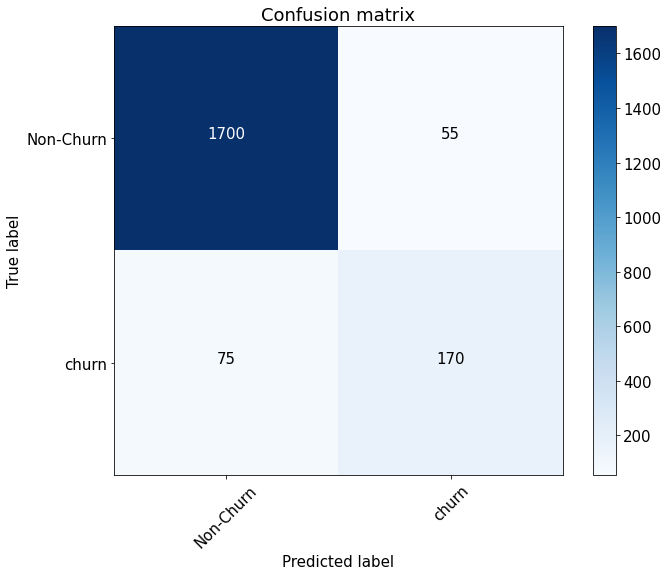

In [42]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [43]:
roc_auc_score(y_test, preds)

0.9528367928367929